# inference

In [51]:
import os
import librosa
import random
import torch
import evaluate
import torchaudio
import numpy as np
import pandas as pd
from datasets import Dataset
from dataclasses import dataclass
from typing import Any, Dict, List, Union

from model.tokenization_whisper import WhisperTokenizer
from model.processing_whisper import WhisperProcessor
from model.feature_extraction_whisper import WhisperFeatureExtractor
from model.modeling_whisper import WhisperForConditionalGeneration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [52]:
device

device(type='cuda')

In [53]:

mp3_path = "./dataset/clips"
# train_tsv = "./dataset/cv-corpus-11.0-2022-09-21/bn/train.tsv"
data_tsv = "./dataset/dev.tsv"

model_path = "/media/sayan/hdd1/ARS/whisper/whisper-small-bn/checkpoint-8000"

In [54]:
def read_data(data_path, data_chunk = 0):
    if data_chunk==0:
        data = pd.read_csv(data_path, sep='\t')
    else:
        data = pd.read_csv(data_path, sep='\t')[:data_chunk]
    data.columns = ["client_id", "path", "sentence", "up_votes", "down_votes", "age", "gender", "accents", "locale", "segment"]
    data = data.drop(["client_id","up_votes", "down_votes", "age", "gender", "accents", "locale", "segment"], axis=1)
    return data

In [55]:
data = read_data(data_tsv, data_chunk=0)

In [56]:
data.head()

,path,sentence
0,common_voice_bn_31684551.mp3,"তিনি ভিডিও গেম ""হাফ-লাইফ: বিপক্ষ বলের"" ক্ষেত্র..."
1,common_voice_bn_31684629.mp3,তবে কর্তৃত্ব প্রদর্শনের জন্য এটি জার্মান সেনাদ...
2,common_voice_bn_31581194.mp3,এই লোকসভা কেন্দ্রের সদর দফতর সুলতানপুর শহরে অব...
3,common_voice_bn_31581200.mp3,একটি উপদলের নেতৃত্বে ছিলেন মোহাম্মদ নূরুল হক।
4,common_voice_bn_31549899.mp3,সুস্থ হওয়ার পর তিনি পার্শ্ববর্তী মির্জাপুর গ্...


In [57]:
def add_file_path(path):
    audio_path = os.path.join(mp3_path, path)
    return audio_path

In [58]:
data['path'] = data['path'].map(lambda x: add_file_path(x))

In [59]:
data

,path,sentence
0,./dataset/clips/common_voice_bn_31684551.mp3,"তিনি ভিডিও গেম ""হাফ-লাইফ: বিপক্ষ বলের"" ক্ষেত্র..."
1,./dataset/clips/common_voice_bn_31684629.mp3,তবে কর্তৃত্ব প্রদর্শনের জন্য এটি জার্মান সেনাদ...
2,./dataset/clips/common_voice_bn_31581194.mp3,এই লোকসভা কেন্দ্রের সদর দফতর সুলতানপুর শহরে অব...
3,./dataset/clips/common_voice_bn_31581200.mp3,একটি উপদলের নেতৃত্বে ছিলেন মোহাম্মদ নূরুল হক।
4,./dataset/clips/common_voice_bn_31549899.mp3,সুস্থ হওয়ার পর তিনি পার্শ্ববর্তী মির্জাপুর গ্...
...,...,...
8348,./dataset/clips/common_voice_bn_30993611.mp3,"অন্যদিকে, জিম্বাবুয়ে দল নিউজিল্যান্ডের বিপক্ষ..."
8349,./dataset/clips/common_voice_bn_31519313.mp3,দশম শতাব্দীতে বাশকিরিয়ায় ইসলাম ধর্ম বিস্তার ...
8350,./dataset/clips/common_voice_bn_31519318.mp3,তাই তিনি কলকাতাতে চলে আসেন এবং সেখানেই বসবাস শ...
8351,./dataset/clips/common_voice_bn_31520056.mp3,"ফেরত বিবেচনার অর্থ হল, সাধারণ আইনে, দান করার জ..."


In [60]:
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_path)
tokenizer = WhisperTokenizer.from_pretrained(model_path)
processor = WhisperProcessor.from_pretrained(model_path)
model = WhisperForConditionalGeneration.from_pretrained(model_path).to(device)

In [61]:
def prepare_dataset(path):
    speech_array, sampling_rate = torchaudio.load(path, format="mp3")
    speech_array = speech_array[0].numpy()
    speech_array = librosa.resample(np.asarray(speech_array), orig_sr=sampling_rate, target_sr=16000)
    input_features = feature_extractor(speech_array, sampling_rate=16000, return_tensors="pt").input_features
    return speech_array, input_features

In [85]:
audio_list, sentence =data["path"].tolist(), data["sentence"].tolist()

In [86]:
# audio_list[100]

# Audio Processing for Inference

In [87]:
index = 10
audio_file, sentence1 = audio_list[index], sentence[index]
speech_array, input_features = prepare_dataset(audio_file)

In [88]:
print(type(speech_array), type(input_features), input_features.shape)

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.Size([1, 80, 3000])


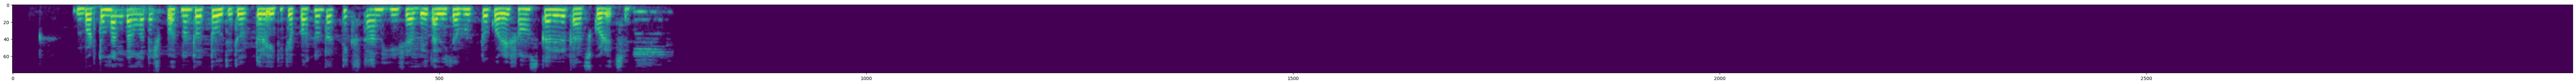

In [89]:
from matplotlib import pyplot as plt

np_feature = input_features[0].detach().cpu().numpy()

plt.figure(figsize=(100,100))
plt.imshow(np_feature)
plt.show()

In [90]:
import IPython.display as ipd
import numpy as np
import random
print(sentence1)
ipd.Audio(data=np.asarray(speech_array), autoplay=True, rate=16000)

বর্তমান বাংলাদেশ প্রত্নতত্ত্ব অধিদপ্তর এটিকে প্রত্নতাত্ত্বিক স্থান হিসেবে তালিকাভুক্ত করে সংস্কারের সংস্কারের কাজ করেছে।


In [91]:
# batch = processor.feature_extractor.pad(input_features, return_tensors="pt")
predicted_ids = model.generate(inputs=input_features.to(device))[0]

In [92]:
transcription = processor.decode(predicted_ids, skip_special_tokens=True)

In [93]:
transcription

'বর্তমান বাংলাদেশ প্রত্নতত্ত্ব অধিদপ্তর এটিকে প্রত্নতাত্ত্বিক স্থান হিসাবে তালিকাভুক্ত করে সংস্কারের কাজ করেছে।'